DEBUG 2024-11-24 14:56:45,982:     Asyncio event loop already running.
DEBUG 2024-11-24 14:56:45,983:     Logger propagate set to False
DEBUG 2024-11-24 14:56:45,984:     Pre-registering run with id 10234726229817035143
DEBUG 2024-11-24 14:56:45,984:     Using InMemoryState
DEBUG 2024-11-24 14:56:45,985:     Using InMemoryState
DEBUG 2024-11-24 14:56:45,987:     Buffer time delay: 5s
INFO 2024-11-24 14:56:45,989:      Starting Flower ServerApp, config: num_rounds=50, no round_timeout
INFO 2024-11-24 14:56:45,990:      
INFO 2024-11-24 14:56:45,991:      [INIT]
INFO 2024-11-24 14:56:45,991:      Using initial global parameters provided by strategy
INFO 2024-11-24 14:56:45,992:      Starting evaluation of initial global parameters
INFO 2024-11-24 14:56:45,992:      Evaluation returned no results (`None`)
INFO 2024-11-24 14:56:45,992:      
INFO 2024-11-24 14:56:45,993:      [ROUND 1]



Running Scenario: Baseline_IID


DEBUG 2024-11-24 14:56:50,987:     Using InMemoryState
DEBUG 2024-11-24 14:56:50,988:     Registered 5 nodes
DEBUG 2024-11-24 14:56:50,988:     Supported backends: ['ray']
DEBUG 2024-11-24 14:56:50,989:     Initialising: RayBackend
DEBUG 2024-11-24 14:56:50,990:     Backend config: {'init_args': {}, 'client_resources': {'num_cpus': 2, 'num_gpus': 0}, 'actor': {'tensorflow': 0}}
2024-11-24 14:56:51,781	INFO worker.py:1819 -- Started a local Ray instance.
INFO 2024-11-24 14:56:52,420:      configure_fit: strategy sampled 2 clients (out of 5)
DEBUG 2024-11-24 14:56:52,438:     Constructed ActorPool with: 16 actors
DEBUG 2024-11-24 14:56:52,439:     Using InMemoryState
(ClientAppActor pid=1381256) /home/fredrik/BTH/DV2607/part2/flower_env/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=1381256)   obj.co_lnotab,  # for < python 3.10 [not counted in args]
INFO 2024-11-24 14:57:02,143:      aggreg

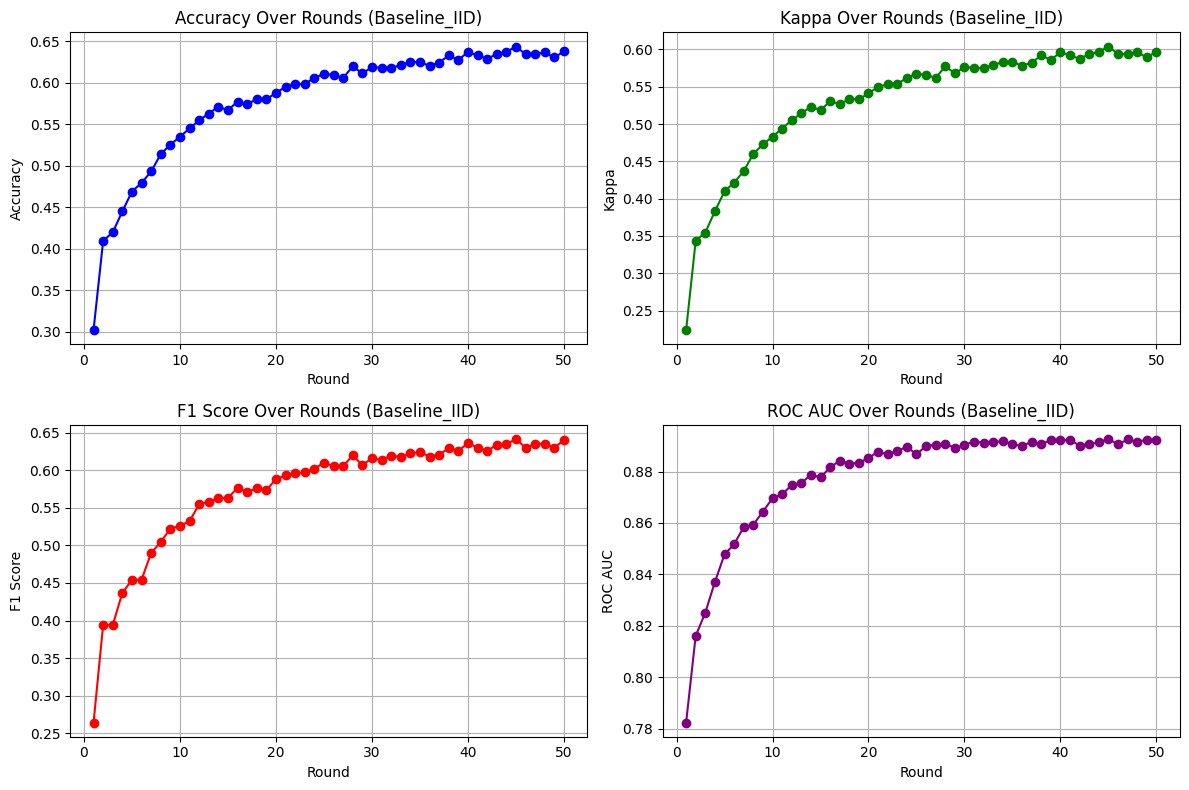

DEBUG 2024-11-24 15:03:29,428:     Asyncio event loop already running.
DEBUG 2024-11-24 15:03:29,429:     Logger propagate set to False
DEBUG 2024-11-24 15:03:29,429:     Pre-registering run with id 4676095489227073318
DEBUG 2024-11-24 15:03:29,430:     Using InMemoryState
DEBUG 2024-11-24 15:03:29,430:     Using InMemoryState
DEBUG 2024-11-24 15:03:29,432:     Buffer time delay: 5s
INFO 2024-11-24 15:03:29,435:      Starting Flower ServerApp, config: num_rounds=50, no round_timeout
INFO 2024-11-24 15:03:29,435:      
INFO 2024-11-24 15:03:29,436:      [INIT]
INFO 2024-11-24 15:03:29,436:      Using initial global parameters provided by strategy
INFO 2024-11-24 15:03:29,437:      Starting evaluation of initial global parameters
INFO 2024-11-24 15:03:29,437:      Evaluation returned no results (`None`)
INFO 2024-11-24 15:03:29,437:      
INFO 2024-11-24 15:03:29,438:      [ROUND 1]



Running Scenario: One_Attacker_IID


DEBUG 2024-11-24 15:03:34,434:     Using InMemoryState
DEBUG 2024-11-24 15:03:34,435:     Registered 5 nodes
DEBUG 2024-11-24 15:03:34,436:     Supported backends: ['ray']
DEBUG 2024-11-24 15:03:34,436:     Initialising: RayBackend
DEBUG 2024-11-24 15:03:34,437:     Backend config: {'init_args': {}, 'client_resources': {'num_cpus': 2, 'num_gpus': 0}, 'actor': {'tensorflow': 0}}
2024-11-24 15:03:35,383	INFO worker.py:1819 -- Started a local Ray instance.
INFO 2024-11-24 15:03:35,878:      configure_fit: strategy sampled 2 clients (out of 5)
DEBUG 2024-11-24 15:03:35,891:     Constructed ActorPool with: 16 actors
DEBUG 2024-11-24 15:03:35,892:     Using InMemoryState
(ClientAppActor pid=1391565) /home/fredrik/BTH/DV2607/part2/flower_env/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=1391565)   obj.co_lnotab,  # for < python 3.10 [not counted in args]
(ClientAppActor pid=1391565) /home/fredri

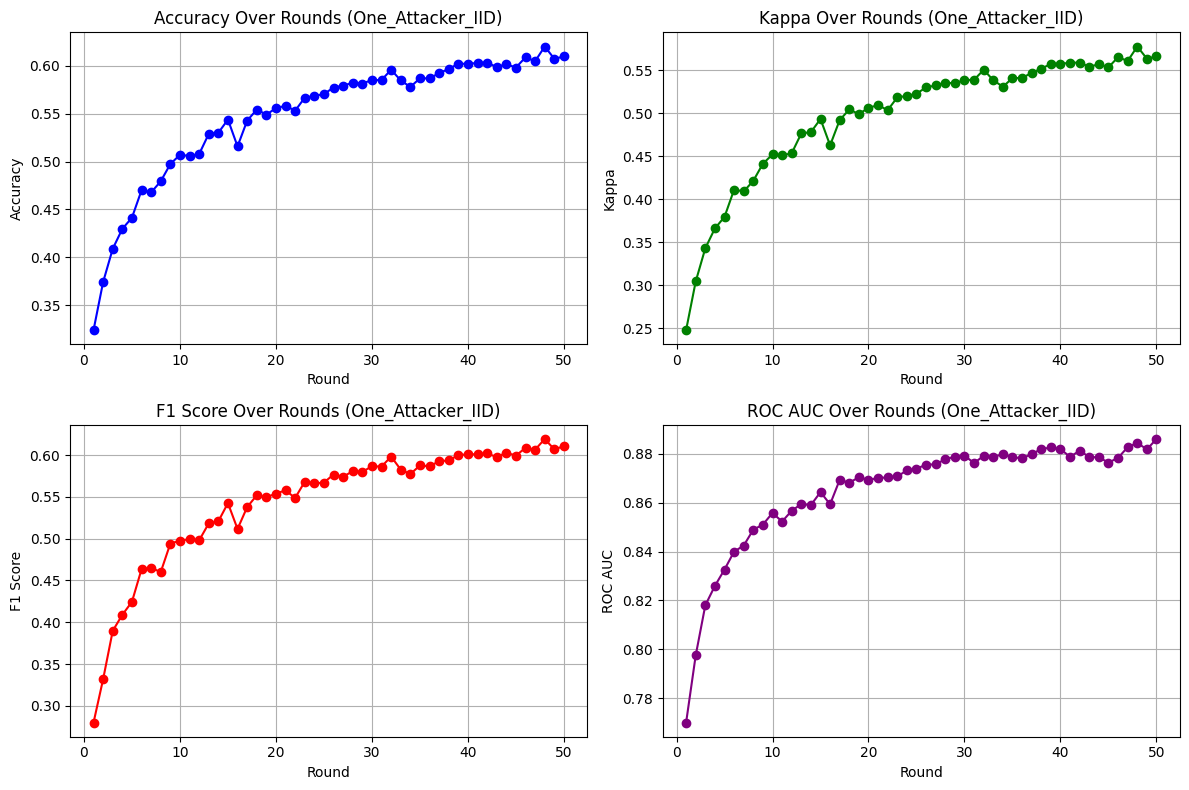

DEBUG 2024-11-24 15:10:18,329:     Asyncio event loop already running.
DEBUG 2024-11-24 15:10:18,330:     Logger propagate set to False
DEBUG 2024-11-24 15:10:18,330:     Pre-registering run with id 1885696870749046807
DEBUG 2024-11-24 15:10:18,331:     Using InMemoryState
DEBUG 2024-11-24 15:10:18,331:     Using InMemoryState
DEBUG 2024-11-24 15:10:18,333:     Buffer time delay: 5s
INFO 2024-11-24 15:10:18,335:      Starting Flower ServerApp, config: num_rounds=50, no round_timeout
INFO 2024-11-24 15:10:18,335:      
INFO 2024-11-24 15:10:18,336:      [INIT]
INFO 2024-11-24 15:10:18,336:      Using initial global parameters provided by strategy
INFO 2024-11-24 15:10:18,336:      Starting evaluation of initial global parameters
INFO 2024-11-24 15:10:18,337:      Evaluation returned no results (`None`)
INFO 2024-11-24 15:10:18,337:      
INFO 2024-11-24 15:10:18,338:      [ROUND 1]



Running Scenario: Two_Attackers_IID


DEBUG 2024-11-24 15:10:23,334:     Using InMemoryState
DEBUG 2024-11-24 15:10:23,335:     Registered 5 nodes
DEBUG 2024-11-24 15:10:23,335:     Supported backends: ['ray']
DEBUG 2024-11-24 15:10:23,336:     Initialising: RayBackend
DEBUG 2024-11-24 15:10:23,336:     Backend config: {'init_args': {}, 'client_resources': {'num_cpus': 2, 'num_gpus': 0}, 'actor': {'tensorflow': 0}}
INFO 2024-11-24 15:10:24,336:      configure_fit: strategy sampled 2 clients (out of 5)
2024-11-24 15:10:24,354	INFO worker.py:1819 -- Started a local Ray instance.
DEBUG 2024-11-24 15:10:24,926:     Constructed ActorPool with: 16 actors
DEBUG 2024-11-24 15:10:24,927:     Using InMemoryState
(ClientAppActor pid=1401888) /home/fredrik/BTH/DV2607/part2/flower_env/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=1401888)   obj.co_lnotab,  # for < python 3.10 [not counted in args]
INFO 2024-11-24 15:10:35,130:      aggreg

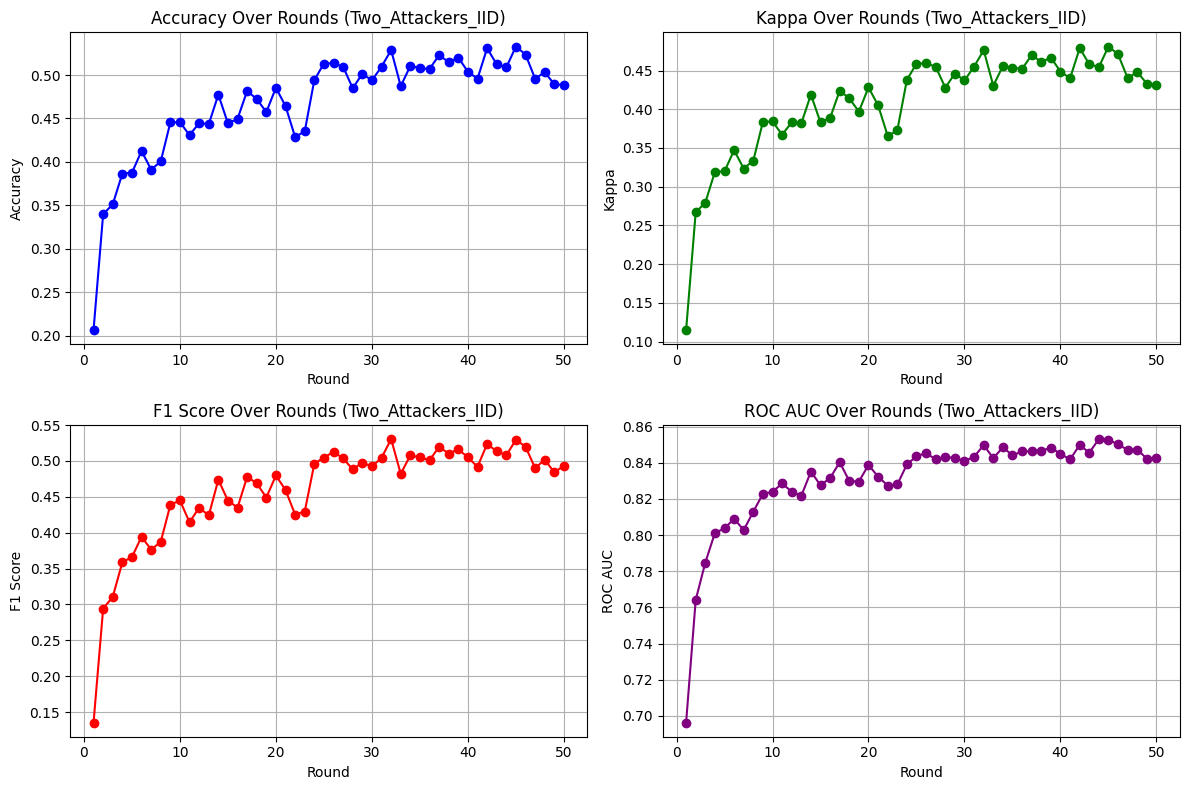

DEBUG 2024-11-24 15:17:18,818:     Asyncio event loop already running.
DEBUG 2024-11-24 15:17:18,819:     Logger propagate set to False
DEBUG 2024-11-24 15:17:18,819:     Pre-registering run with id 12289396957483861164
DEBUG 2024-11-24 15:17:18,820:     Using InMemoryState
DEBUG 2024-11-24 15:17:18,821:     Using InMemoryState
DEBUG 2024-11-24 15:17:18,822:     Buffer time delay: 5s
INFO 2024-11-24 15:17:18,824:      Starting Flower ServerApp, config: num_rounds=50, no round_timeout
INFO 2024-11-24 15:17:18,825:      
INFO 2024-11-24 15:17:18,826:      [INIT]
INFO 2024-11-24 15:17:18,826:      Using initial global parameters provided by strategy
INFO 2024-11-24 15:17:18,826:      Starting evaluation of initial global parameters
INFO 2024-11-24 15:17:18,827:      Evaluation returned no results (`None`)
INFO 2024-11-24 15:17:18,827:      
INFO 2024-11-24 15:17:18,827:      [ROUND 1]



Running Scenario: Baseline_NonIID


DEBUG 2024-11-24 15:17:23,823:     Using InMemoryState
DEBUG 2024-11-24 15:17:23,824:     Registered 5 nodes
DEBUG 2024-11-24 15:17:23,824:     Supported backends: ['ray']
DEBUG 2024-11-24 15:17:23,825:     Initialising: RayBackend
DEBUG 2024-11-24 15:17:23,825:     Backend config: {'init_args': {}, 'client_resources': {'num_cpus': 2, 'num_gpus': 0}, 'actor': {'tensorflow': 0}}
INFO 2024-11-24 15:17:24,826:      configure_fit: strategy sampled 2 clients (out of 5)
2024-11-24 15:17:25,709	INFO worker.py:1819 -- Started a local Ray instance.
DEBUG 2024-11-24 15:17:26,225:     Constructed ActorPool with: 16 actors
DEBUG 2024-11-24 15:17:26,226:     Using InMemoryState
(ClientAppActor pid=1411129) /home/fredrik/BTH/DV2607/part2/flower_env/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=1411129)   obj.co_lnotab,  # for < python 3.10 [not counted in args]
INFO 2024-11-24 15:17:37,731:      aggreg

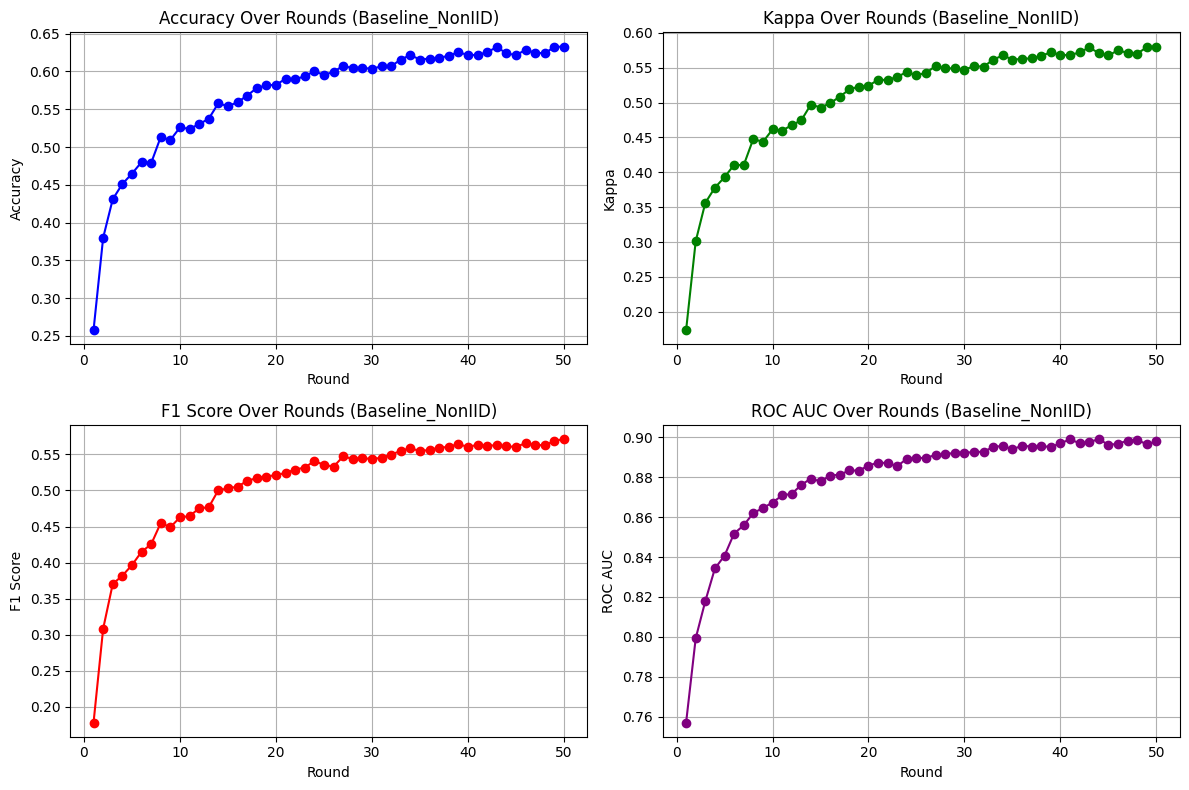

DEBUG 2024-11-24 15:24:45,521:     Asyncio event loop already running.
DEBUG 2024-11-24 15:24:45,522:     Logger propagate set to False
DEBUG 2024-11-24 15:24:45,522:     Pre-registering run with id 14661479786145416120
DEBUG 2024-11-24 15:24:45,523:     Using InMemoryState
DEBUG 2024-11-24 15:24:45,523:     Using InMemoryState
DEBUG 2024-11-24 15:24:45,524:     Buffer time delay: 5s
INFO 2024-11-24 15:24:45,527:      Starting Flower ServerApp, config: num_rounds=50, no round_timeout
INFO 2024-11-24 15:24:45,527:      
INFO 2024-11-24 15:24:45,528:      [INIT]
INFO 2024-11-24 15:24:45,528:      Using initial global parameters provided by strategy
INFO 2024-11-24 15:24:45,528:      Starting evaluation of initial global parameters
INFO 2024-11-24 15:24:45,528:      Evaluation returned no results (`None`)
INFO 2024-11-24 15:24:45,529:      
INFO 2024-11-24 15:24:45,529:      [ROUND 1]



Running Scenario: One_Attacker_NonIID


DEBUG 2024-11-24 15:24:50,526:     Using InMemoryState
DEBUG 2024-11-24 15:24:50,526:     Registered 5 nodes
DEBUG 2024-11-24 15:24:50,527:     Supported backends: ['ray']
DEBUG 2024-11-24 15:24:50,527:     Initialising: RayBackend
DEBUG 2024-11-24 15:24:50,528:     Backend config: {'init_args': {}, 'client_resources': {'num_cpus': 2, 'num_gpus': 0}, 'actor': {'tensorflow': 0}}
2024-11-24 15:24:51,379	INFO worker.py:1819 -- Started a local Ray instance.
INFO 2024-11-24 15:24:51,906:      configure_fit: strategy sampled 2 clients (out of 5)
DEBUG 2024-11-24 15:24:51,921:     Constructed ActorPool with: 16 actors
DEBUG 2024-11-24 15:24:51,922:     Using InMemoryState
(ClientAppActor pid=1419950) /home/fredrik/BTH/DV2607/part2/flower_env/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=1419950)   obj.co_lnotab,  # for < python 3.10 [not counted in args]
(ClientAppActor pid=1419950) /home/fredri

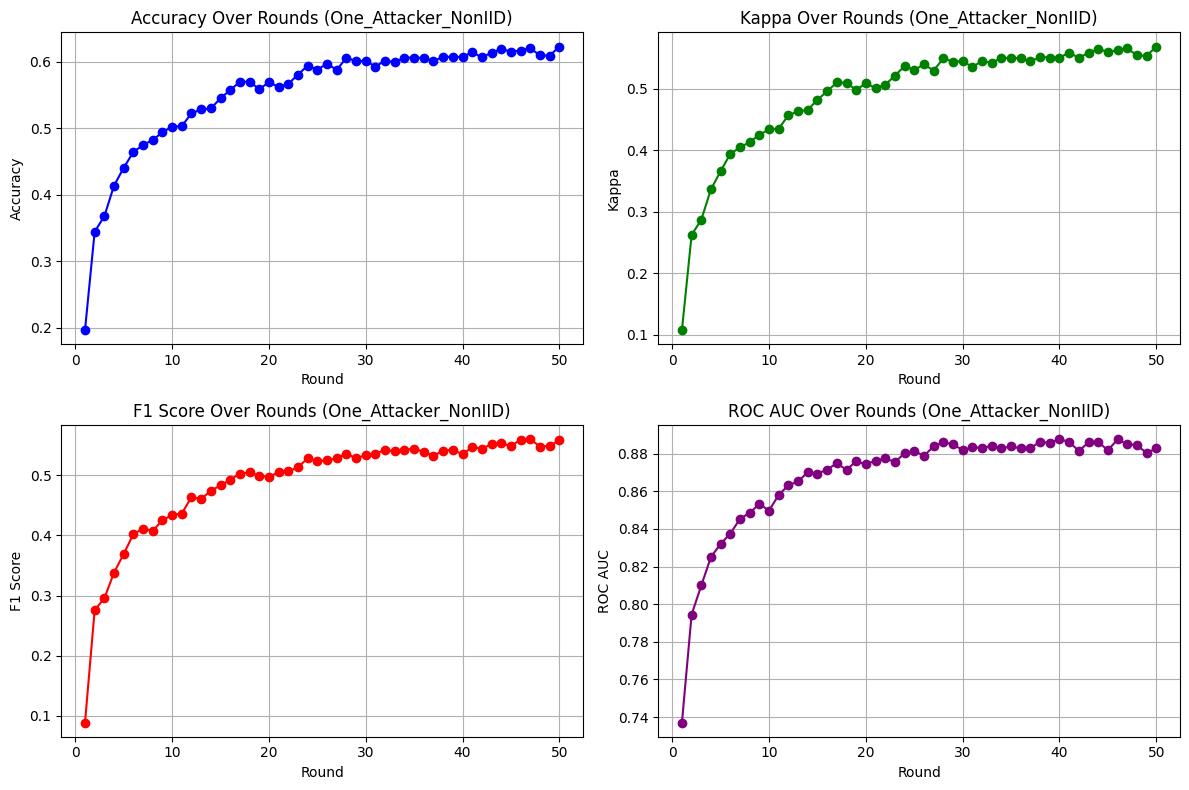

DEBUG 2024-11-24 15:32:03,363:     Asyncio event loop already running.
DEBUG 2024-11-24 15:32:03,364:     Logger propagate set to False
DEBUG 2024-11-24 15:32:03,364:     Pre-registering run with id 1260581627260150926
DEBUG 2024-11-24 15:32:03,365:     Using InMemoryState
DEBUG 2024-11-24 15:32:03,366:     Using InMemoryState
DEBUG 2024-11-24 15:32:03,367:     Buffer time delay: 5s
INFO 2024-11-24 15:32:03,369:      Starting Flower ServerApp, config: num_rounds=50, no round_timeout
INFO 2024-11-24 15:32:03,370:      
INFO 2024-11-24 15:32:03,371:      [INIT]
INFO 2024-11-24 15:32:03,371:      Using initial global parameters provided by strategy
INFO 2024-11-24 15:32:03,371:      Starting evaluation of initial global parameters
INFO 2024-11-24 15:32:03,372:      Evaluation returned no results (`None`)
INFO 2024-11-24 15:32:03,372:      
INFO 2024-11-24 15:32:03,372:      [ROUND 1]



Running Scenario: Two_Attackers_NonIID


DEBUG 2024-11-24 15:32:08,368:     Using InMemoryState
DEBUG 2024-11-24 15:32:08,369:     Registered 5 nodes
DEBUG 2024-11-24 15:32:08,370:     Supported backends: ['ray']
DEBUG 2024-11-24 15:32:08,371:     Initialising: RayBackend
DEBUG 2024-11-24 15:32:08,371:     Backend config: {'init_args': {}, 'client_resources': {'num_cpus': 2, 'num_gpus': 0}, 'actor': {'tensorflow': 0}}
INFO 2024-11-24 15:32:09,371:      configure_fit: strategy sampled 2 clients (out of 5)
2024-11-24 15:32:10,329	INFO worker.py:1819 -- Started a local Ray instance.
DEBUG 2024-11-24 15:32:10,823:     Constructed ActorPool with: 16 actors
DEBUG 2024-11-24 15:32:10,824:     Using InMemoryState
(ClientAppActor pid=1428750) /home/fredrik/BTH/DV2607/part2/flower_env/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=1428750)   obj.co_lnotab,  # for < python 3.10 [not counted in args]
(ClientAppActor pid=1428750) /home/fredri

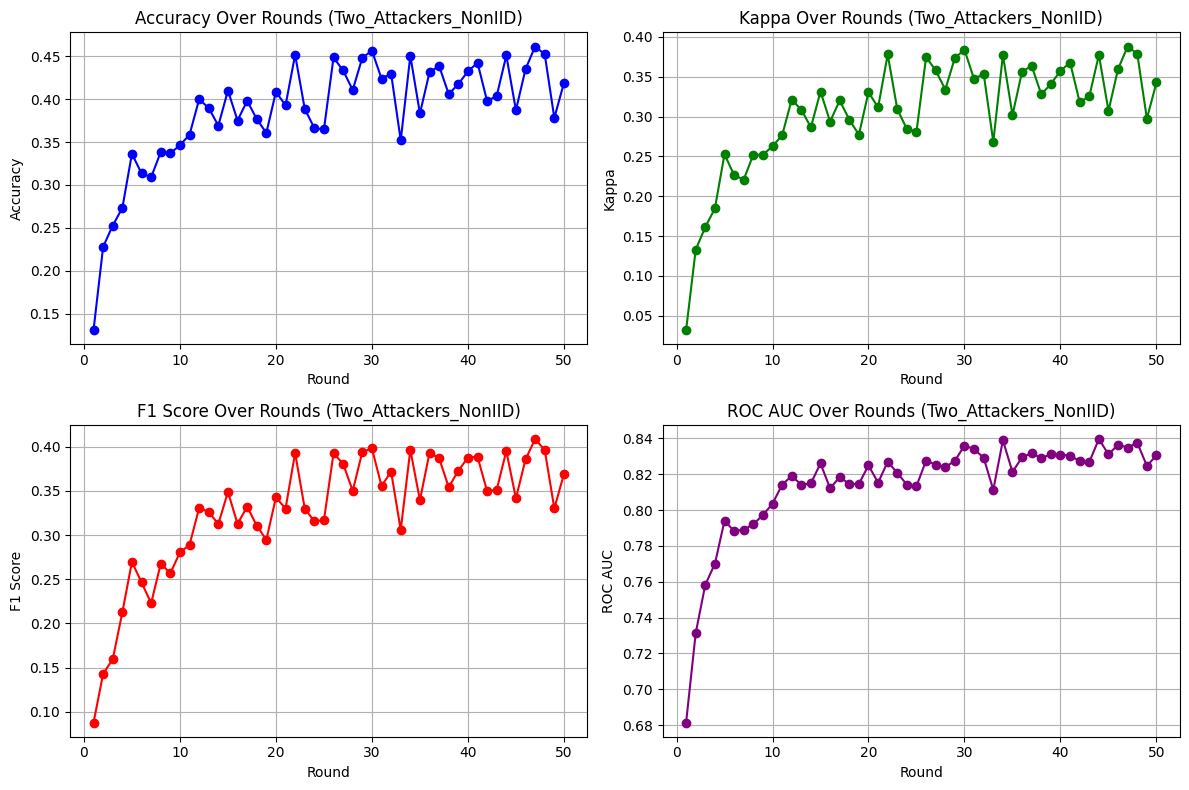

In [1]:
# Import necessary libraries
import torch
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor, Normalize, Compose
from datasets import load_dataset
import numpy as np
from flwr_datasets import FederatedDataset
from flwr_datasets.partitioner import IidPartitioner, DirichletPartitioner
from flwr.client import NumPyClient
from flwr.common import Context, NDArrays, Scalar, ndarrays_to_parameters, EvaluateRes
from flwr.server import ServerApp, ServerConfig, ServerAppComponents
from flwr.server.strategy import FedProx  # Changed from FedAvg to FedProx
from flwr.simulation import run_simulation
from collections import OrderedDict
from typing import Dict, Tuple, List
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import cohen_kappa_score, f1_score, roc_auc_score
from sklearn.preprocessing import label_binarize
from flwr.server.client_proxy import ClientProxy
from flwr.common.logger import log
from logging import INFO

# Additional imports for plotting and data saving
import matplotlib.pyplot as plt
import pandas as pd
import random
import os

# Set random seeds for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed()

# Define constants
NUM_CLIENTS = 5
NUM_ROUNDS = 50
BATCH_SIZE = 32

# Function to run simulation for a given scenario
def run_simulation_scenario(ATTACKER_IDS, USE_IID):
    # Define partitioner based on IID or non-IID
    if USE_IID:
        # IID Partitioning
        partitioner = IidPartitioner(num_partitions=NUM_CLIENTS)
    else:
        # Non-IID Partitioning using Dirichlet distribution
        alpha = 1.0  # Adjust alpha for desired heterogeneity
        partitioner = DirichletPartitioner(num_partitions=NUM_CLIENTS, alpha=alpha, partition_by="label")

    # Load the CIFAR-10 dataset and partition it
    fds = FederatedDataset(dataset="cifar10", partitioners={"train": partitioner})

    def get_cifar10_dataloaders(cifar10_dataset, batch_size: int):
        """
        Function to handle CIFAR-10 data loaders.
        Applies appropriate transformations for CIFAR-10 images.
        """
        # CIFAR-10 normalization parameters
        pytorch_transforms = Compose([
            ToTensor(),
            Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
        ])

        # Prepare transformation functions
        def apply_transforms(batch):
            """Apply transforms to the partition from FederatedDataset."""
            batch["img"] = [pytorch_transforms(img) for img in batch["img"]]
            return batch

        cifar10_dataset = cifar10_dataset.with_transform(apply_transforms)

        # Construct PyTorch dataloader
        dataloader = DataLoader(cifar10_dataset, batch_size=batch_size, shuffle=True)
        return dataloader

    # Define the neural network model suitable for CIFAR-10
    class Net(nn.Module):
        def __init__(self, num_classes: int) -> None:
            super(Net, self).__init__()
            self.conv1 = nn.Conv2d(3, 6, 5)  # Changed input channels from 1 to 3 for CIFAR-10
            self.pool = nn.MaxPool2d(2, 2)
            self.conv2 = nn.Conv2d(6, 16, 5)
            self.fc1 = nn.Linear(16 * 5 * 5, 120)  # Adjusted for 32x32 images
            self.fc2 = nn.Linear(120, 84)
            self.fc3 = nn.Linear(84, num_classes)

        def forward(self, x: torch.Tensor) -> torch.Tensor:
            x = self.pool(F.relu(self.conv1(x)))
            x = self.pool(F.relu(self.conv2(x)))
            x = x.view(-1, 16 * 5 * 5)
            x = F.relu(self.fc1(x))
            x = F.relu(self.fc2(x))
            x = self.fc3(x)
            return x

    # Functions to set and get model parameters
    def set_params(model, parameters):
        """Replace model parameters with those passed as parameters."""
        params_dict = zip(model.state_dict().keys(), parameters)
        state_dict = OrderedDict({k: torch.from_numpy(v) for k, v in params_dict})
        model.load_state_dict(state_dict, strict=True)

    def get_params(model):
        """Extract model parameters as a list of NumPy arrays."""
        return [val.cpu().numpy() for _, val in model.state_dict().items()]

    # Training function with label flipping for attackers and proximal term
    def train(net, trainloader, optimizer, device="cpu", is_attacker=False, global_params=None, mu=0.1):
        """Train the network on the training set with optional proximal term."""
        criterion = torch.nn.CrossEntropyLoss()
        net.to(device)
        net.train()
        for batch in trainloader:
            images, labels = batch["img"].to(device), batch["label"].to(device)
            optimizer.zero_grad()
            if is_attacker:
                # Flip labels for attackers (simple label flipping)
                labels = (labels + 1) % 10
            outputs = net(images)
            loss = criterion(outputs, labels)
            if global_params is not None:
                # Add proximal term
                proximal_loss = 0.0
                for param, global_param in zip(net.parameters(), global_params.values()):
                    proximal_loss += torch.norm(param - global_param.to(device))**2
                loss += (mu / 2) * proximal_loss
            loss.backward()
            optimizer.step()

    # Testing function with metric calculations
    def test(net, testloader, device):
        """Validate the network on the entire test set."""
        criterion = torch.nn.CrossEntropyLoss()
        net.to(device)
        net.eval()
        correct, loss = 0, 0.0
        all_preds = []
        all_labels = []
        all_outputs = []
        with torch.no_grad():
            for batch in testloader:
                images, labels = batch["img"].to(device), batch["label"].to(device)
                outputs = net(images)
                loss += criterion(outputs, labels).item()
                _, predicted = torch.max(outputs.data, 1)
                correct += (predicted == labels).sum().item()
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
                all_outputs.extend(outputs.cpu().numpy())
        accuracy = correct / len(testloader.dataset)

        # Compute metrics
        kappa = cohen_kappa_score(all_labels, all_preds)
        f1 = f1_score(all_labels, all_preds, average='macro')

        # Check if there are at least two classes in y_true
        unique_classes = np.unique(all_labels)
        if len(unique_classes) > 1:
            try:
                all_labels_bin = label_binarize(all_labels, classes=list(range(10)))
                all_outputs_array = np.array(all_outputs)
                roc_auc = roc_auc_score(all_labels_bin, all_outputs_array, average='macro', multi_class='ovr')
            except ValueError:
                roc_auc = float('nan')  # Assign NaN if ROC AUC cannot be computed
        else:
            roc_auc = float('nan')  # Assign NaN if only one class is present

        metrics = {
            "accuracy": accuracy,
            "kappa": kappa,
            "f1_score": f1,
            "roc_auc": roc_auc,
        }
        return loss, accuracy, metrics

    # Initialize metrics lists
    rounds_list = []
    accuracy_list = []
    kappa_list = []
    f1_list = []
    roc_auc_list = []

    # Define the FlowerClient class
    class FlowerClient(NumPyClient):
        def __init__(self, trainloader, valloader, is_attacker=False) -> None:
            super().__init__()
            self.trainloader = trainloader
            self.valloader = valloader
            self.model = Net(num_classes=10)
            self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
            self.is_attacker = is_attacker

        def fit(self, parameters, config):
            """Train the model locally with FedProx proximal term."""
            # Set model parameters
            set_params(self.model, parameters)

            # Extract global parameters from config
            global_params = OrderedDict(
                (k, torch.tensor(v)) for k, v in zip(self.model.state_dict().keys(), parameters)
            )

            # Get proximal_mu from config
            mu = config.get("proximal_mu", 0.1)  # Default to 0.1 if not set

            # Define the optimizer
            optim = torch.optim.SGD(self.model.parameters(), lr=0.01, momentum=0.9)

            # Train the model with proximal term
            train(
                self.model,
                self.trainloader,
                optim,
                self.device,
                is_attacker=self.is_attacker,
                global_params=global_params,
                mu=mu  # Proximal term coefficient
            )

            # Return updated parameters
            return get_params(self.model), len(self.trainloader.dataset), {}

        def evaluate(self, parameters: NDArrays, config: Dict[str, Scalar]):
            """Evaluate the model locally."""
            set_params(self.model, parameters)
            loss, accuracy, metrics = test(self.model, self.valloader, self.device)
            return float(loss), len(self.valloader.dataset), metrics

    # Define the client function
    def client_fn(context: Context):
        """Create a Flower client representing a participant in the federated learning."""
        partition_id = int(context.node_config["partition-id"])
        partition = fds.load_partition(partition_id, "train")
        # Partition into train/validation
        partition_train_val = partition.train_test_split(test_size=0.1, seed=42)
        # Get dataloaders
        trainloader = get_cifar10_dataloaders(partition_train_val["train"], batch_size=BATCH_SIZE)
        valloader = get_cifar10_dataloaders(partition_train_val["test"], batch_size=BATCH_SIZE)
        # Determine if the client is an attacker
        is_attacker = partition_id in ATTACKER_IDS
        return FlowerClient(trainloader=trainloader, valloader=valloader, is_attacker=is_attacker).to_client()

    # Define function to provide fit config with proximal_mu
    def fit_config(rnd: int):
        """Return training configuration dict for each round."""
        return {"proximal_mu": 0.1}  # Set proximal_mu value

    # Define custom strategy to log metrics
    class CustomFedProx(FedProx):  # Changed from CustomFedAvg to CustomFedProx and FedProx
        def __init__(self, *args, **kwargs):
            self.rounds_list = kwargs.pop('rounds_list')
            self.accuracy_list = kwargs.pop('accuracy_list')
            self.kappa_list = kwargs.pop('kappa_list')
            self.f1_list = kwargs.pop('f1_list')
            self.roc_auc_list = kwargs.pop('roc_auc_list')
            proximal_mu = kwargs.pop('proximal_mu', 0.1)  # Extract proximal_mu
            super().__init__(*args, proximal_mu=proximal_mu, **kwargs)  # Pass proximal_mu to FedProx

        def aggregate_evaluate(
            self,
            rnd: int,
            results: List[Tuple[ClientProxy, EvaluateRes]],
            failures: List[BaseException],
        ):
            """Aggregate evaluation results using weighted average and log metrics per round."""
            if not results:
                return None, {}

            # Use weighted average to aggregate metrics
            num_examples_total = sum([r[1].num_examples for r in results])

            # Initialize sums
            accuracy_sum = 0.0
            kappa_sum = 0.0
            f1_sum = 0.0
            roc_auc_sum = 0.0
            roc_auc_weight = 0

            for _, evaluate_res in results:
                accuracy_sum += evaluate_res.metrics.get("accuracy", 0.0) * evaluate_res.num_examples
                kappa_sum += evaluate_res.metrics.get("kappa", 0.0) * evaluate_res.num_examples
                f1_sum += evaluate_res.metrics.get("f1_score", 0.0) * evaluate_res.num_examples
                roc_auc = evaluate_res.metrics.get("roc_auc", float('nan'))
                if not np.isnan(roc_auc):
                    roc_auc_sum += roc_auc * evaluate_res.num_examples
                    roc_auc_weight += evaluate_res.num_examples

            # Compute weighted averages
            accuracy = accuracy_sum / num_examples_total
            kappa = kappa_sum / num_examples_total
            f1 = f1_sum / num_examples_total
            roc_auc = roc_auc_sum / roc_auc_weight if roc_auc_weight > 0 else float('nan')

            # Log metrics
            log(INFO, f"Round {rnd} evaluation metrics:")
            log(INFO, f"Accuracy: {accuracy:.4f}")
            log(INFO, f"Kappa: {kappa:.4f}")
            log(INFO, f"F1 Score: {f1:.4f}")
            if not np.isnan(roc_auc):
                log(INFO, f"ROC AUC: {roc_auc:.4f}")
            else:
                log(INFO, f"ROC AUC: Undefined (only one class present in y_true)")

            # Store metrics
            self.rounds_list.append(rnd)
            self.accuracy_list.append(accuracy)
            self.kappa_list.append(kappa)
            self.f1_list.append(f1)
            self.roc_auc_list.append(roc_auc if not np.isnan(roc_auc) else 0.0)

            # Return aggregated loss and metrics
            return super().aggregate_evaluate(rnd, results, failures)

    # Define the server function
    def server_fn(context: Context):
        # Instantiate the model
        model = Net(num_classes=10)
        ndarrays = get_params(model)
        # Convert model parameters to flwr.common.Parameters
        global_model_init = ndarrays_to_parameters(ndarrays)

        # Define the strategy with FedProx parameters
        strategy = CustomFedProx(
            fraction_fit=1.0,        # All clients participate in training
            fraction_evaluate=1.0,   # All clients participate in evaluation
            initial_parameters=global_model_init,  # Initialized global model
            rounds_list=rounds_list,
            accuracy_list=accuracy_list,
            kappa_list=kappa_list,
            f1_list=f1_list,
            roc_auc_list=roc_auc_list,
            proximal_mu=0.1,  # Proximal term coefficient for FedProx
            on_fit_config_fn=fit_config  # Function to provide fit config
        )

        # Construct ServerConfig
        config = ServerConfig(num_rounds=NUM_ROUNDS)

        # Wrap everything into a ServerAppComponents object
        return ServerAppComponents(strategy=strategy, config=config)

    # Create your ServerApp and ClientApp
    server_app = ServerApp(server_fn=server_fn)
    from flwr.client import ClientApp
    client_app = ClientApp(client_fn=client_fn)

    # Run the simulation
    run_simulation(
        server_app=server_app,
        client_app=client_app,
        num_supernodes=NUM_CLIENTS,
        backend_name="ray",
        verbose_logging=True,
    )

    # After the simulation, collect the metrics
    metrics = {
        "rounds": rounds_list,
        "accuracy": accuracy_list,
        "kappa": kappa_list,
        "f1_score": f1_list,
        "roc_auc": roc_auc_list,
    }

    return metrics

# Function to run all scenarios
def run_all_scenarios():
    scenarios = [
        {"name": "Baseline_IID", "ATTACKER_IDS": [], "USE_IID": True},
        {"name": "One_Attacker_IID", "ATTACKER_IDS": [0], "USE_IID": True},
        {"name": "Two_Attackers_IID", "ATTACKER_IDS": [0, 1], "USE_IID": True},
        {"name": "Baseline_NonIID", "ATTACKER_IDS": [], "USE_IID": False},
        {"name": "One_Attacker_NonIID", "ATTACKER_IDS": [0], "USE_IID": False},
        {"name": "Two_Attackers_NonIID", "ATTACKER_IDS": [0, 1], "USE_IID": False},
    ]

    results = {}

    for scenario in scenarios:
        print(f"\nRunning Scenario: {scenario['name']}")
        metrics = run_simulation_scenario(scenario["ATTACKER_IDS"], scenario["USE_IID"])
        results[scenario["name"]] = metrics

        # Plot the metrics
        plt.figure(figsize=(12, 8))

        plt.subplot(2, 2, 1)
        plt.plot(metrics["rounds"], metrics["accuracy"], marker='o', color='blue')
        plt.title(f"Accuracy Over Rounds ({scenario['name']})")
        plt.xlabel('Round')
        plt.ylabel('Accuracy')
        plt.grid(True)

        plt.subplot(2, 2, 2)
        plt.plot(metrics["rounds"], metrics["kappa"], marker='o', color='green')
        plt.title(f"Kappa Over Rounds ({scenario['name']})")
        plt.xlabel('Round')
        plt.ylabel('Kappa')
        plt.grid(True)

        plt.subplot(2, 2, 3)
        plt.plot(metrics["rounds"], metrics["f1_score"], marker='o', color='red')
        plt.title(f"F1 Score Over Rounds ({scenario['name']})")
        plt.xlabel('Round')
        plt.ylabel("F1 Score")
        plt.grid(True)

        plt.subplot(2, 2, 4)
        plt.plot(metrics["rounds"], metrics["roc_auc"], marker='o', color='purple')
        plt.title(f"ROC AUC Over Rounds ({scenario['name']})")
        plt.xlabel('Round')
        plt.ylabel("ROC AUC")
        plt.grid(True)

        plt.tight_layout()
        plt.show()

        # Save metrics to CSV
        df = pd.DataFrame(metrics)
        df.to_csv(f"FedProx_{scenario['name']}_metrics.csv", index=False)

    return results

# Run all scenarios
results = run_all_scenarios()


In [17]:
# Define the list of scenarios
scenarios = [
    "Baseline_IID",
    "One_Attacker_IID",
    "Two_Attackers_IID",
    "Baseline_NonIID",
    "One_Attacker_NonIID",
    "Two_Attackers_NonIID",
]

# Initialize a dictionary to store DataFrames
dataframes = {}

# Load each CSV file into a DataFrame
for scenario in scenarios:
    filename = f"FedProx_{scenario}_metrics.csv"
    if os.path.exists(filename):
        df = pd.read_csv(filename)
        dataframes[scenario] = df
        print(f"Loaded {filename} successfully.")
    else:
        print(f"Warning: {filename} does not exist and will be skipped.")

# Verify the loaded data
for scenario, df in dataframes.items():
    print(f"\nFirst few rows for FedProx {scenario}:")
    display(df.head())


Loaded FedProx_Baseline_IID_metrics.csv successfully.
Loaded FedProx_One_Attacker_IID_metrics.csv successfully.
Loaded FedProx_Two_Attackers_IID_metrics.csv successfully.
Loaded FedProx_Baseline_NonIID_metrics.csv successfully.
Loaded FedProx_One_Attacker_NonIID_metrics.csv successfully.
Loaded FedProx_Two_Attackers_NonIID_metrics.csv successfully.

First few rows for FedProx Baseline_IID:


,rounds,accuracy,kappa,f1_score,roc_auc
0,1,0.3020,0.223918,0.264342,0.782459
1,2,0.4096,0.343680,0.394163,0.816175
2,3,0.4198,0.354612,0.394079,0.825152
3,4,0.4450,0.383190,0.436848,0.837099
4,5,0.4690,0.409857,0.454030,0.847767



First few rows for FedProx One_Attacker_IID:


,rounds,accuracy,kappa,f1_score,roc_auc
0,1,0.3242,0.247625,0.279977,0.770113
1,2,0.3744,0.304145,0.331958,0.797540
2,3,0.4090,0.342843,0.389716,0.818010
3,4,0.4298,0.365921,0.408892,0.825950
4,5,0.4414,0.379379,0.424414,0.832619



First few rows for FedProx Two_Attackers_IID:


,rounds,accuracy,kappa,f1_score,roc_auc
0,1,0.2066,0.114874,0.135457,0.696308
1,2,0.3400,0.266974,0.294213,0.764137
2,3,0.3512,0.279408,0.310518,0.784768
3,4,0.3866,0.319215,0.358776,0.801180
4,5,0.3876,0.319894,0.366012,0.803715



First few rows for FedProx Baseline_NonIID:


,rounds,accuracy,kappa,f1_score,roc_auc
0,1,0.257845,0.173932,0.178275,0.757075
1,2,0.379972,0.301282,0.308295,0.799276
2,3,0.430941,0.356255,0.370437,0.817885
3,4,0.451129,0.378051,0.381837,0.834249
4,5,0.464721,0.393022,0.396518,0.840644



First few rows for FedProx One_Attacker_NonIID:


,rounds,accuracy,kappa,f1_score,roc_auc
0,1,0.196882,0.107787,0.089042,0.737137
1,2,0.344593,0.262388,0.276008,0.794484
2,3,0.367779,0.286960,0.295434,0.809924
3,4,0.413752,0.336622,0.338374,0.825086
4,5,0.440536,0.365883,0.369194,0.832053



First few rows for FedProx Two_Attackers_NonIID:


,rounds,accuracy,kappa,f1_score,roc_auc
0,1,0.130722,0.032105,0.087789,0.681481
1,2,0.227863,0.133034,0.142994,0.731400
2,3,0.252648,0.161274,0.159440,0.758380
3,4,0.273236,0.184815,0.212505,0.770050
4,5,0.336398,0.252813,0.269682,0.794067


In [18]:
# Combine all DataFrames into a single DataFrame for easier comparison
combined_df = pd.DataFrame()

for scenario, df in dataframes.items():
    temp_df = df.copy()
    temp_df['Scenario'] = scenario
    combined_df = pd.concat([combined_df, temp_df], ignore_index=True)

output_file = "FedProx_combined_metrics.csv"
combined_df.to_csv(output_file, index=False)

# Display the combined DataFrame
print("Combined DataFrame:")
display(combined_df.head())


Combined DataFrame:


,rounds,accuracy,kappa,f1_score,roc_auc,Scenario
0,1,0.3020,0.223918,0.264342,0.782459,Baseline_IID
1,2,0.4096,0.343680,0.394163,0.816175,Baseline_IID
2,3,0.4198,0.354612,0.394079,0.825152,Baseline_IID
3,4,0.4450,0.383190,0.436848,0.837099,Baseline_IID
4,5,0.4690,0.409857,0.454030,0.847767,Baseline_IID


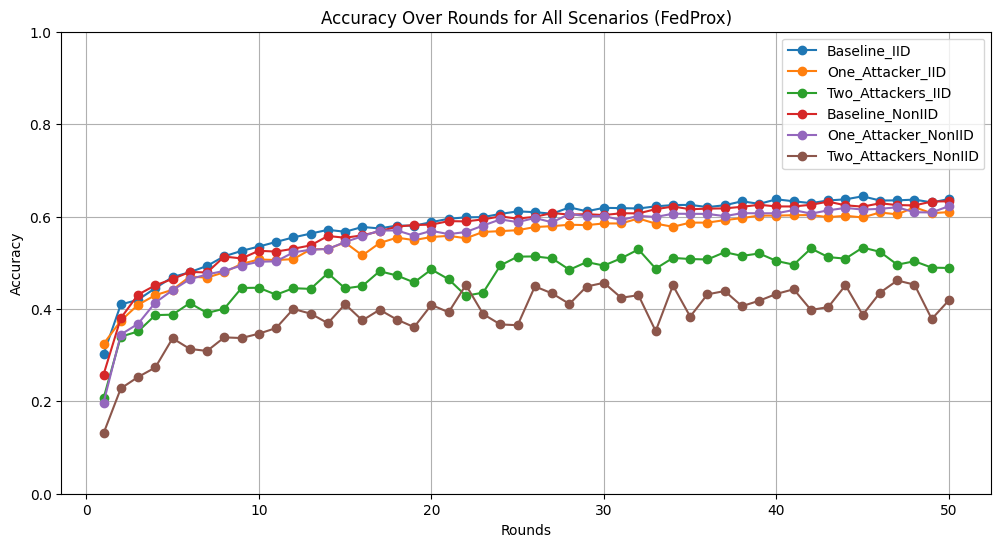

In [19]:
# Plot Accuracy Over Rounds for All Scenarios
plt.figure(figsize=(12, 6))

for scenario in scenarios:
    if scenario in dataframes:
        df = dataframes[scenario]
        plt.plot(df['rounds'], df['accuracy'], marker='o', label=scenario)

plt.title('Accuracy Over Rounds for All Scenarios (FedProx)')
plt.xlabel('Rounds')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.grid(True)
plt.legend()
plt.show()


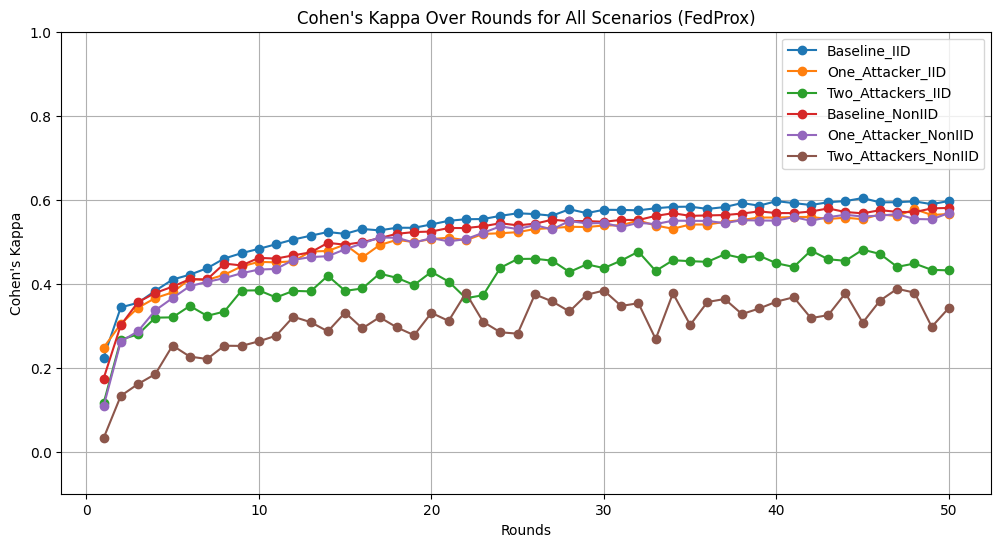

In [20]:
# Plot Cohen's Kappa Over Rounds for All Scenarios
plt.figure(figsize=(12, 6))

for scenario in scenarios:
    if scenario in dataframes:
        df = dataframes[scenario]
        plt.plot(df['rounds'], df['kappa'], marker='o', label=scenario)

plt.title("Cohen's Kappa Over Rounds for All Scenarios (FedProx)")
plt.xlabel('Rounds')
plt.ylabel('Cohen\'s Kappa')
plt.ylim(-0.1, 1)
plt.grid(True)
plt.legend()
plt.show()


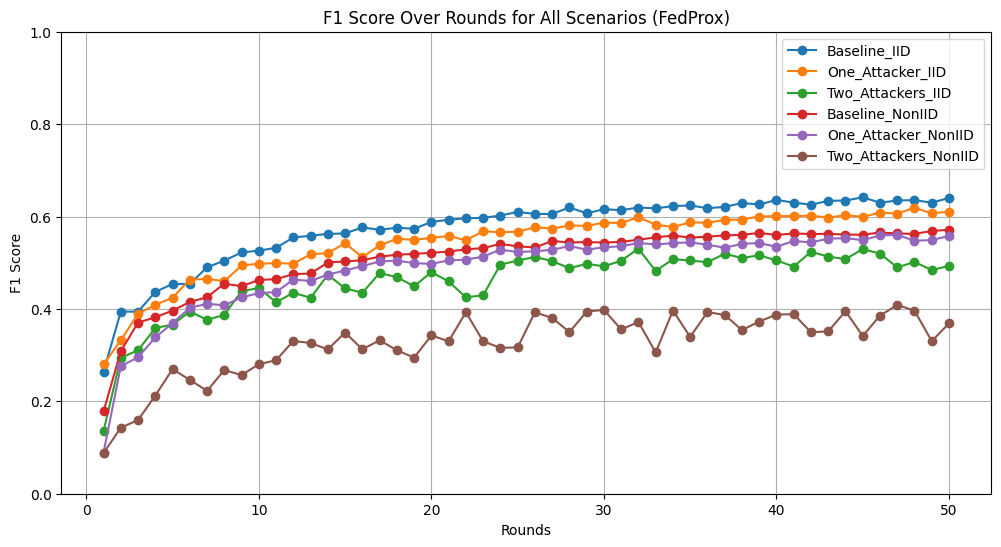

In [6]:
# Plot F1 Score Over Rounds for All Scenarios
plt.figure(figsize=(12, 6))

for scenario in scenarios:
    if scenario in dataframes:
        df = dataframes[scenario]
        plt.plot(df['rounds'], df['f1_score'], marker='o', label=scenario)

plt.title('F1 Score Over Rounds for All Scenarios (FedProx)')
plt.xlabel('Rounds')
plt.ylabel('F1 Score')
plt.ylim(0, 1)
plt.grid(True)
plt.legend()
plt.show()


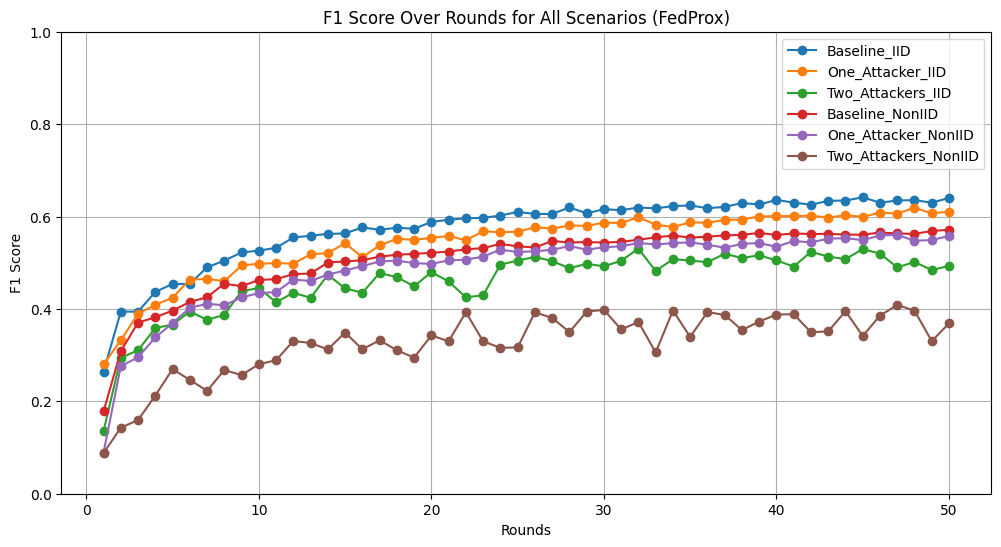

In [7]:
# Plot F1 Score Over Rounds for All Scenarios
plt.figure(figsize=(12, 6))

for scenario in scenarios:
    if scenario in dataframes:
        df = dataframes[scenario]
        plt.plot(df['rounds'], df['f1_score'], marker='o', label=scenario)

plt.title('F1 Score Over Rounds for All Scenarios (FedProx)')
plt.xlabel('Rounds')
plt.ylabel('F1 Score')
plt.ylim(0, 1)
plt.grid(True)
plt.legend()
plt.show()


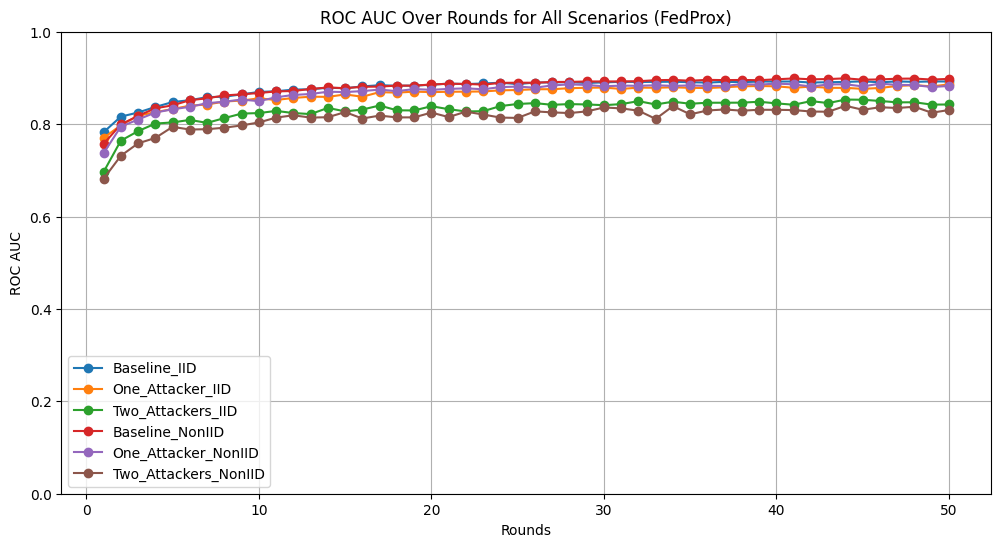

In [8]:
# Plot ROC AUC Over Rounds for All Scenarios
plt.figure(figsize=(12, 6))

for scenario in scenarios:
    if scenario in dataframes:
        df = dataframes[scenario]
        plt.plot(df['rounds'], df['roc_auc'], marker='o', label=scenario)

plt.title('ROC AUC Over Rounds for All Scenarios (FedProx)')
plt.xlabel('Rounds')
plt.ylabel('ROC AUC')
plt.ylim(0, 1)
plt.grid(True)
plt.legend()
plt.show()


In [9]:
# Create a summary table of final metrics for all scenarios
summary_metrics = []

for scenario in scenarios:
    if scenario in dataframes:
        df = dataframes[scenario]
        final_round = df['rounds'].max()
        final_metrics = df[df['rounds'] == final_round].iloc[0]
        summary_metrics.append({
            'Scenario': scenario,
            'Final Round': final_round,
            'Accuracy': final_metrics['accuracy'],
            'Kappa': final_metrics['kappa'],
            'F1 Score': final_metrics['f1_score'],
            'ROC AUC': final_metrics['roc_auc']
        })

# Create a DataFrame for the summary
summary_df = pd.DataFrame(summary_metrics)

# Display the summary table
print("Summary of Final Metrics for All Scenarios (FedProx):")
display(summary_df)


Summary of Final Metrics for All Scenarios (FedProx):


,Scenario,Final Round,Accuracy,Kappa,F1 Score,ROC AUC
0,Baseline_IID,50,0.637800,0.597164,0.640243,0.892262
1,One_Attacker_IID,50,0.609600,0.566124,0.610622,0.885965
2,Two_Attackers_IID,50,0.488600,0.431775,0.493303,0.842498
3,Baseline_NonIID,50,0.633020,0.580422,0.571306,0.897934
4,One_Attacker_NonIID,50,0.622626,0.568464,0.557822,0.882694
5,Two_Attackers_NonIID,50,0.418949,0.342751,0.368817,0.830560


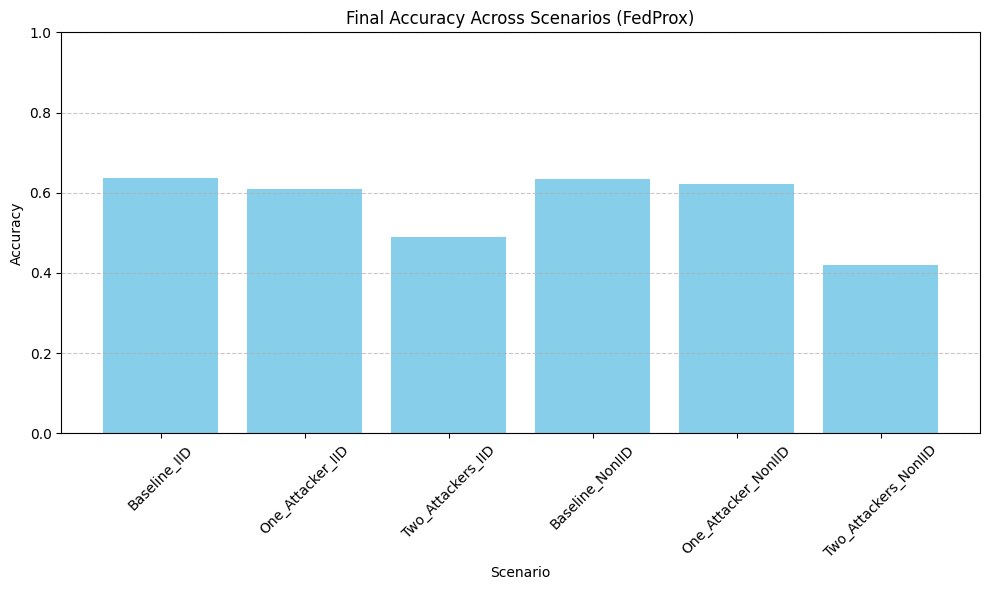

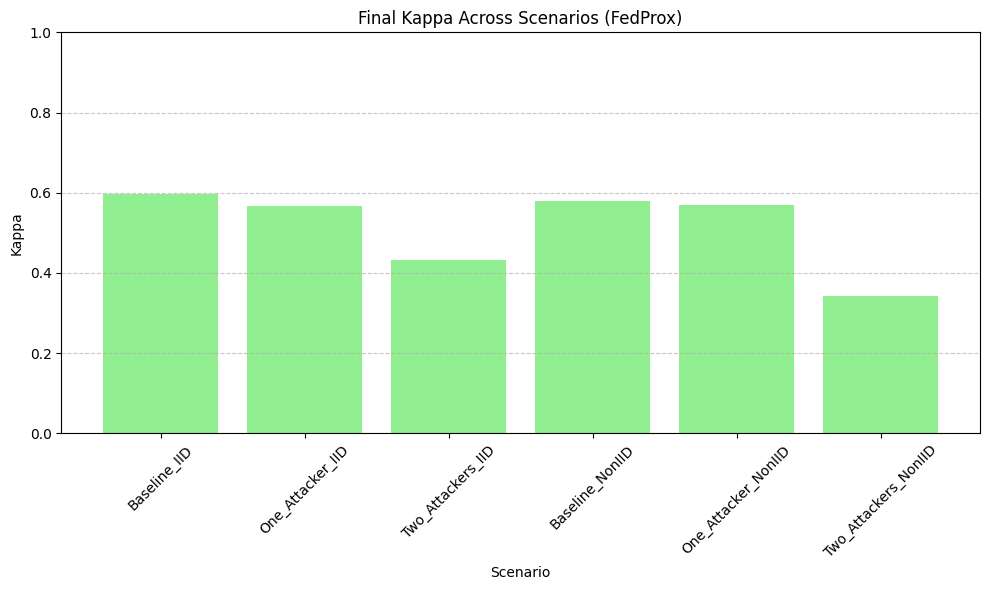

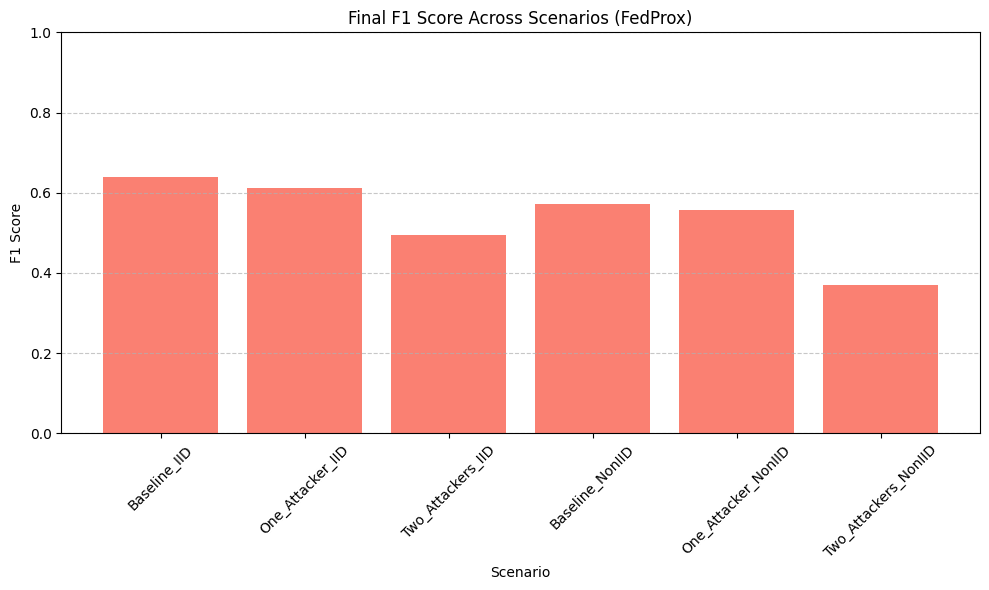

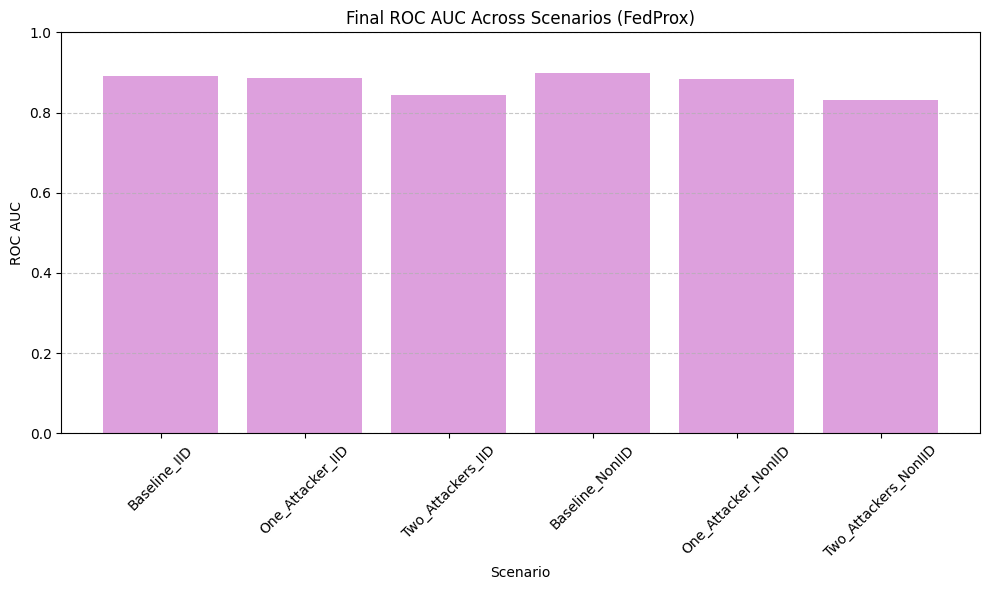

In [10]:
# Plot bar charts to compare final metrics across scenarios

metrics = ['Accuracy', 'Kappa', 'F1 Score', 'ROC AUC']
colors = ['skyblue', 'lightgreen', 'salmon', 'plum']

for metric, color in zip(metrics, colors):
    plt.figure(figsize=(10, 6))
    plt.bar(summary_df['Scenario'], summary_df[metric], color=color)
    plt.title(f'Final {metric} Across Scenarios (FedProx)')
    plt.xlabel('Scenario')
    plt.ylabel(metric)
    plt.ylim(0, 1)
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()


### Comparison Between FedAvg and FedProx

In [21]:
# Load FedAvg and FedProx metrics datasets
fedavg_path = 'FedAvg_combined_metrics.csv'
fedprox_path = 'FedProx_combined_metrics.csv'

fedavg_data = pd.read_csv(fedavg_path)
fedprox_data = pd.read_csv(fedprox_path)

# Display the first few rows to confirm loading
print("FedAvg Data Preview:")
display(fedavg_data.head())

print("\nFedProx Data Preview:")
display(fedprox_data.head())


FedAvg Data Preview:


,rounds,accuracy,kappa,f1_score,roc_auc,Scenario
0,1,0.3494,0.276678,0.319213,0.800053,Baseline_IID
1,2,0.4338,0.370969,0.417903,0.834082,Baseline_IID
2,3,0.4820,0.423898,0.471955,0.847317,Baseline_IID
3,4,0.5046,0.449248,0.497852,0.857085,Baseline_IID
4,5,0.5452,0.494179,0.542888,0.868404,Baseline_IID



FedProx Data Preview:


,rounds,accuracy,kappa,f1_score,roc_auc,Scenario
0,1,0.3020,0.223918,0.264342,0.782459,Baseline_IID
1,2,0.4096,0.343680,0.394163,0.816175,Baseline_IID
2,3,0.4198,0.354612,0.394079,0.825152,Baseline_IID
3,4,0.4450,0.383190,0.436848,0.837099,Baseline_IID
4,5,0.4690,0.409857,0.454030,0.847767,Baseline_IID


In [22]:
# Define unique scenarios and metrics
scenarios = fedavg_data['Scenario'].unique()
metrics = ['accuracy', 'kappa', 'f1_score', 'roc_auc']


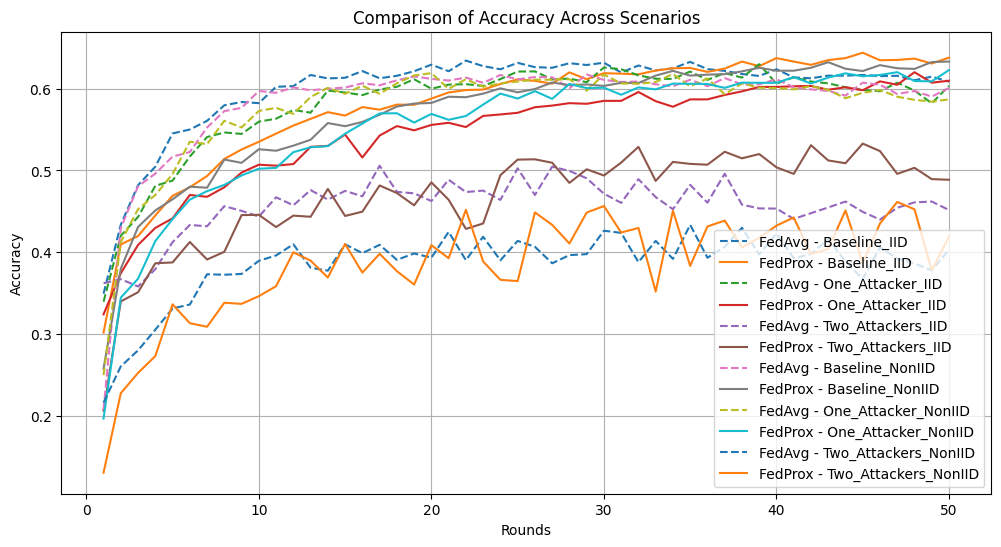

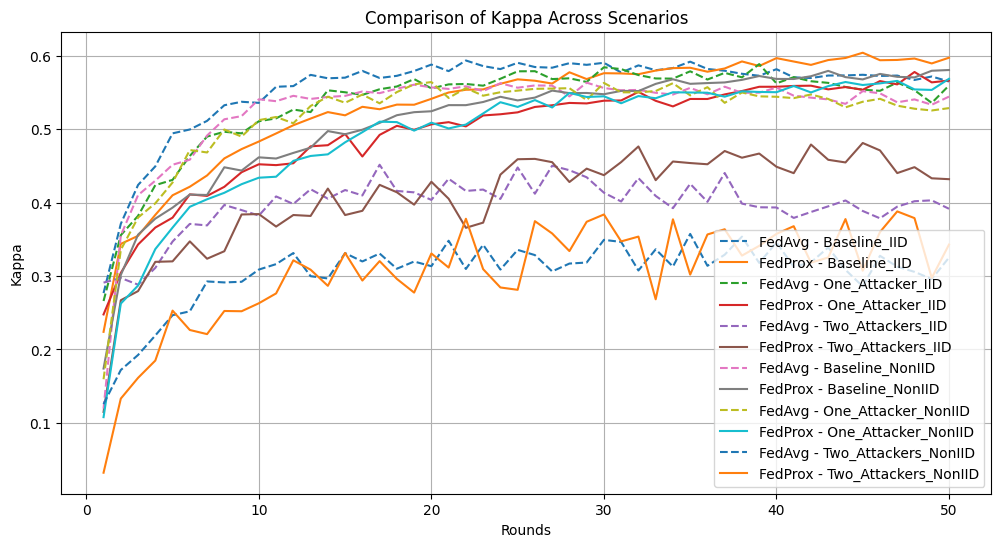

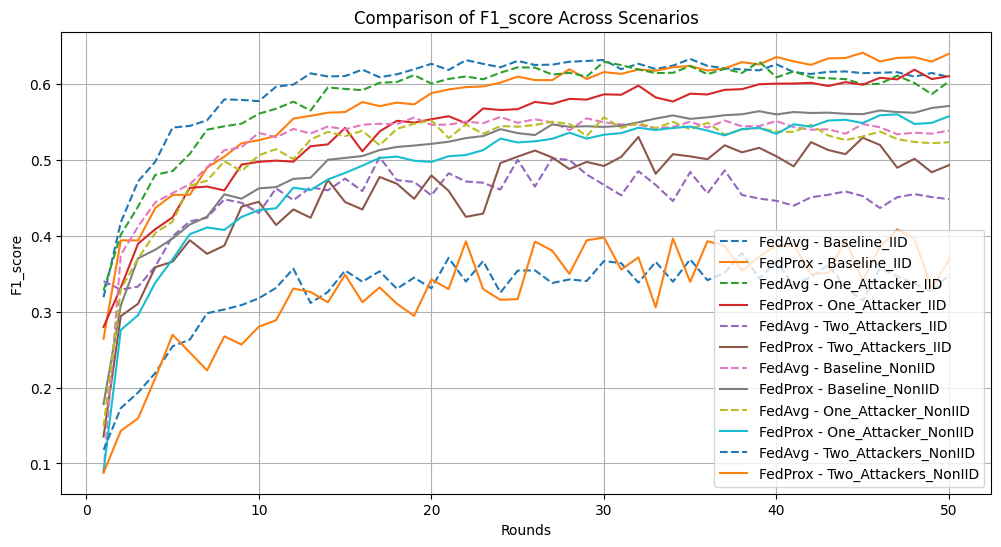

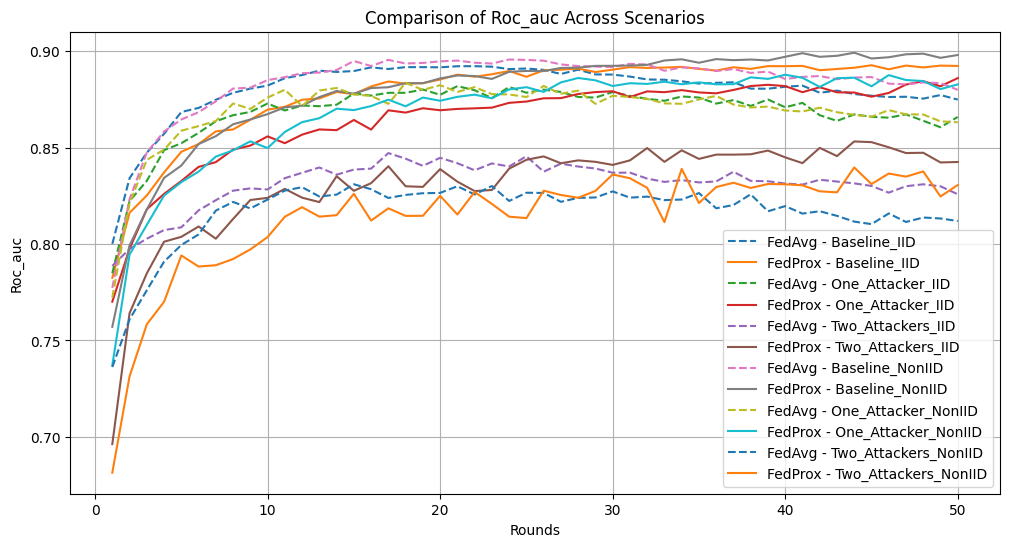

In [23]:
# Plot comparison for each metric
for metric in metrics:
    plt.figure(figsize=(12, 6))
    for scenario in scenarios:
        # Filter data for each scenario
        fedavg_scenario = fedavg_data[fedavg_data['Scenario'] == scenario]
        fedprox_scenario = fedprox_data[fedprox_data['Scenario'] == scenario]
        
        # Plot FedAvg and FedProx metrics for the scenario
        plt.plot(fedavg_scenario['rounds'], fedavg_scenario[metric], label=f'FedAvg - {scenario}', linestyle='--')
        plt.plot(fedprox_scenario['rounds'], fedprox_scenario[metric], label=f'FedProx - {scenario}')
    
    plt.title(f'Comparison of {metric.capitalize()} Across Scenarios')
    plt.xlabel('Rounds')
    plt.ylabel(metric.capitalize())
    plt.legend()
    plt.grid(True)
    plt.show()


In [24]:
# Group data by scenario and compute the mean for each metric
fedavg_summary = fedavg_data.groupby('Scenario').mean()[metrics]
fedprox_summary = fedprox_data.groupby('Scenario').mean()[metrics]

# Combine summaries for comparison
comparison_summary = pd.concat([fedavg_summary, fedprox_summary], keys=['FedAvg', 'FedProx'], axis=1)

# Display the comparison summary
print("FedAvg vs. FedProx Summary:")
display(comparison_summary)


FedAvg vs. FedProx Summary:


FedAvg                                 FedProx  \
                      accuracy     kappa  f1_score   roc_auc  accuracy   
Scenario                                                                 
Baseline_IID          0.599344  0.554627  0.597096  0.880055  0.579408   
Baseline_NonIID       0.583282  0.525493  0.521905  0.883240  0.569838   
One_Attacker_IID      0.581748  0.535285  0.582538  0.868246  0.548388   
One_Attacker_NonIID   0.577214  0.517840  0.511581  0.869096  0.553856   
Two_Attackers_IID     0.457116  0.397300  0.450538  0.831369  0.467732   
Two_Attackers_NonIID  0.385741  0.305470  0.325843  0.816659  0.385409   

                                                    
                         kappa  f1_score   roc_auc  
Scenario                                            
Baseline_IID          0.532449  0.574248  0.878523  
Baseline_NonIID       0.510622  0.508314  0.879240  
One_Attacker_IID      0.498186  0.543253  0.865144  
One_Attacker_NonIID   0.492379  0.488061  0.868310  
Two_Attackers_IID     0.408625  0.459053  0.830925  
Two_Attackers_NonIID  0.305296  0.326513  0.814324

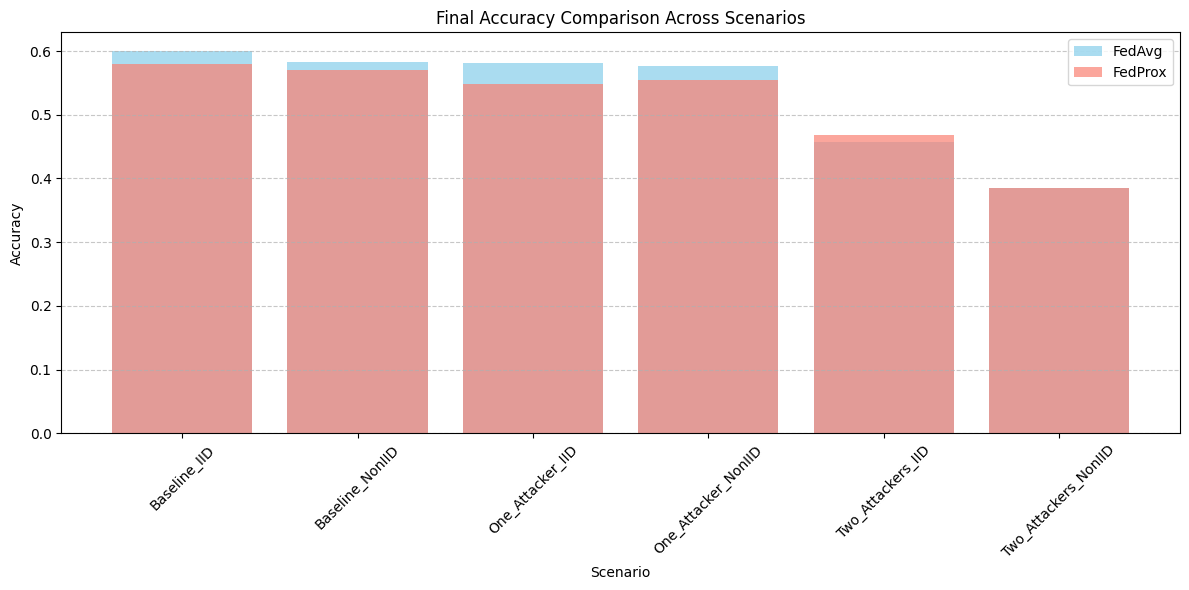

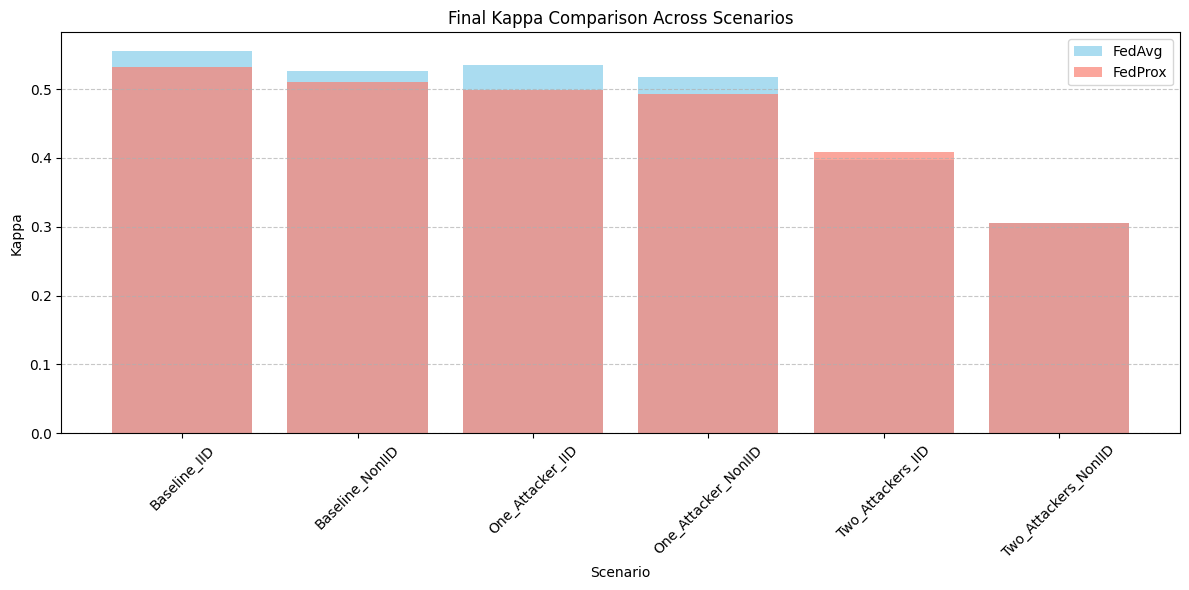

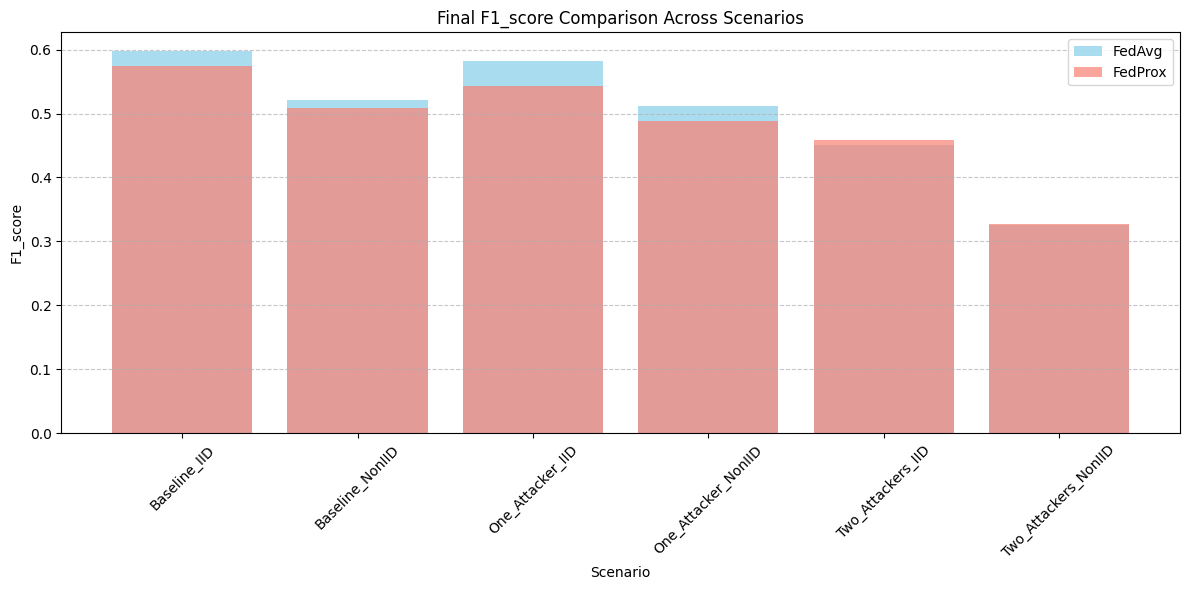

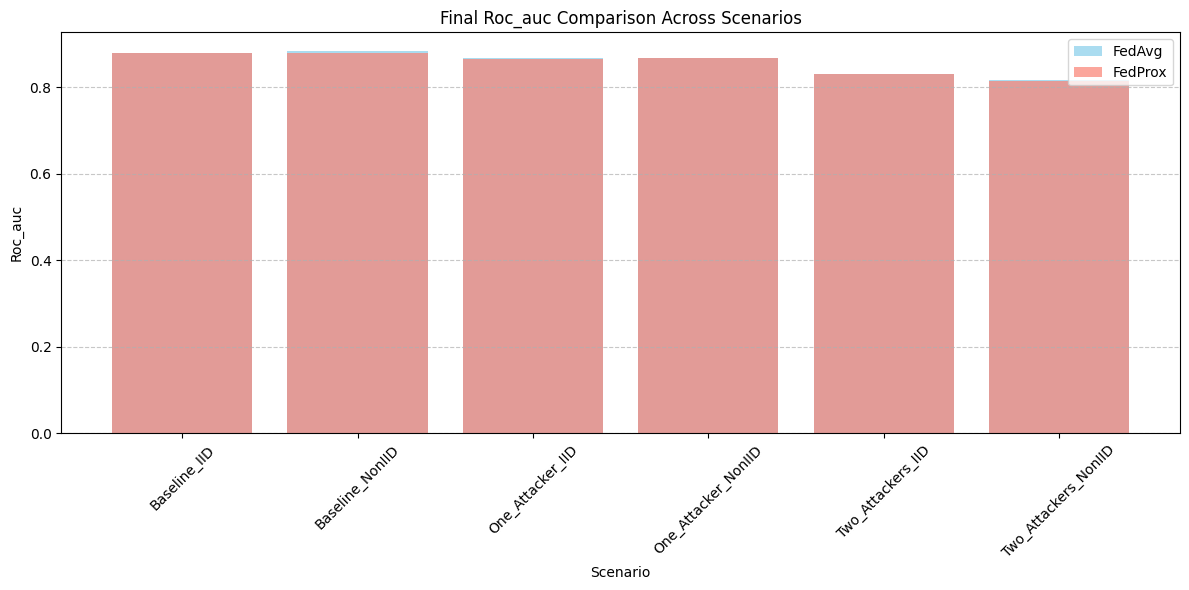

In [15]:
# Plot bar charts for final metrics across scenarios
metrics = ['accuracy', 'kappa', 'f1_score', 'roc_auc']
colors = ['skyblue', 'lightgreen', 'salmon', 'plum']

for metric, color in zip(metrics, colors):
    plt.figure(figsize=(12, 6))
    plt.bar(comparison_summary.index, comparison_summary[('FedAvg', metric)], label='FedAvg', color='skyblue', alpha=0.7)
    plt.bar(comparison_summary.index, comparison_summary[('FedProx', metric)], label='FedProx', color='salmon', alpha=0.7)
    plt.title(f'Final {metric.capitalize()} Comparison Across Scenarios')
    plt.xlabel('Scenario')
    plt.ylabel(metric.capitalize())
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
